# Rival

Topic clustering of [@nosilverv](https://twitter.com/nosilverv)'s tweets with OpenAI embeddings and gaussian process time series priors (a la [Kernel Topic Models](http://proceedings.mlr.press/v22/hennig12/hennig12.pdf))

In [1]:
%load_ext autoreload
%autoreload 2

import umap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from data import Tweets
from embed import Embeddings
from sklearn.cluster import KMeans

## 1. Get data

In [2]:
tweets = Tweets('nosilverv')
tweets.run() # pass True if backfilling

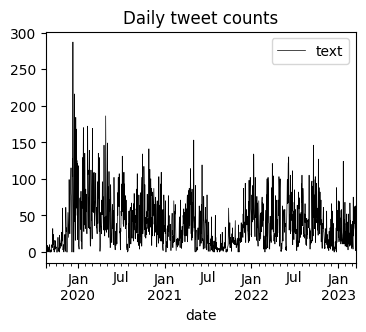

In [3]:
tweets.data.groupby('date').count().resample('D').sum().plot(
    c = 'k', lw = .5, figsize=(4,3), title = 'Daily tweet counts'
);

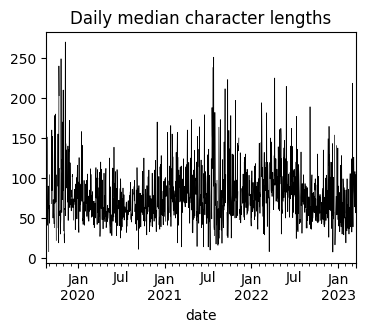

In [4]:
tweets.data.set_index('date').dropna().text.apply(lambda y: len(y)).resample('D').median().plot(
    c = 'k', lw = .5, figsize=(4,3), title = 'Daily median character lengths'
);

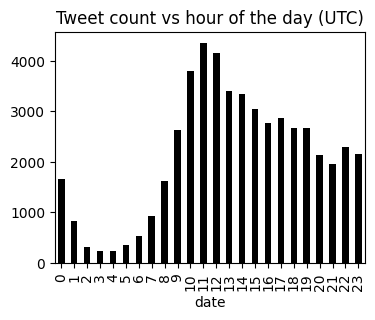

In [5]:
tweets.data.groupby(tweets.data.date.dt.hour).size().plot.bar(
    color = 'k', figsize=(4,3), title = 'Tweet count vs hour of the day (UTC)'
);

## 2. Get embeddings

First, remove handles and empty tweets:

In [6]:
data = tweets.data.copy()
[data.text.replace(*args, regex = True, inplace = True) for args in [
    (r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)', ''), 
    (r'^\s*$', np.nan)
]]
data.dropna(inplace = True)

In [7]:
emb = Embeddings('nosilverv', data)
emb.run()

In [8]:
emb.embeddings.shape

(49240, 1536)

## 3. Exploratory analysis

A 10-dimensional UMAP projection:

In [113]:
proj = umap.UMAP(
    n_components = 10,
    n_neighbors = 200,
    min_dist = 0.,
    metric = 'cosine'
).fit_transform(emb.embeddings.values)

Scatter plot of the first two dimensions:

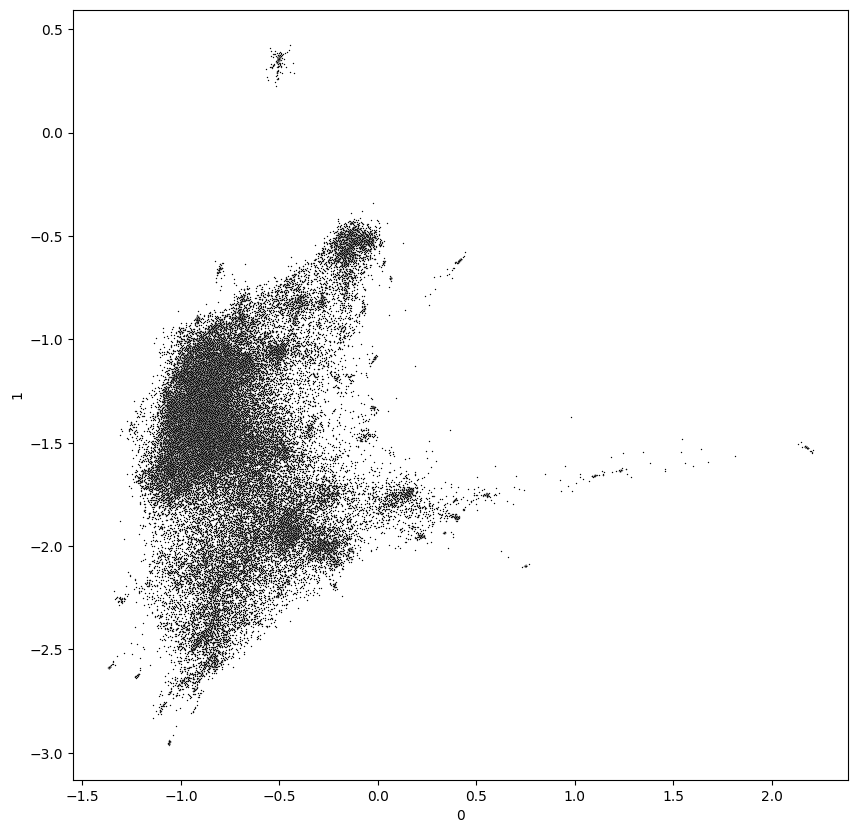

In [166]:
plt.figure(figsize = (10,10))
sns.scatterplot(
    data = pd.DataFrame(proj),
    x = 0, y = 1, legend = False, color = 'k', s = 1
);

All dimensions:

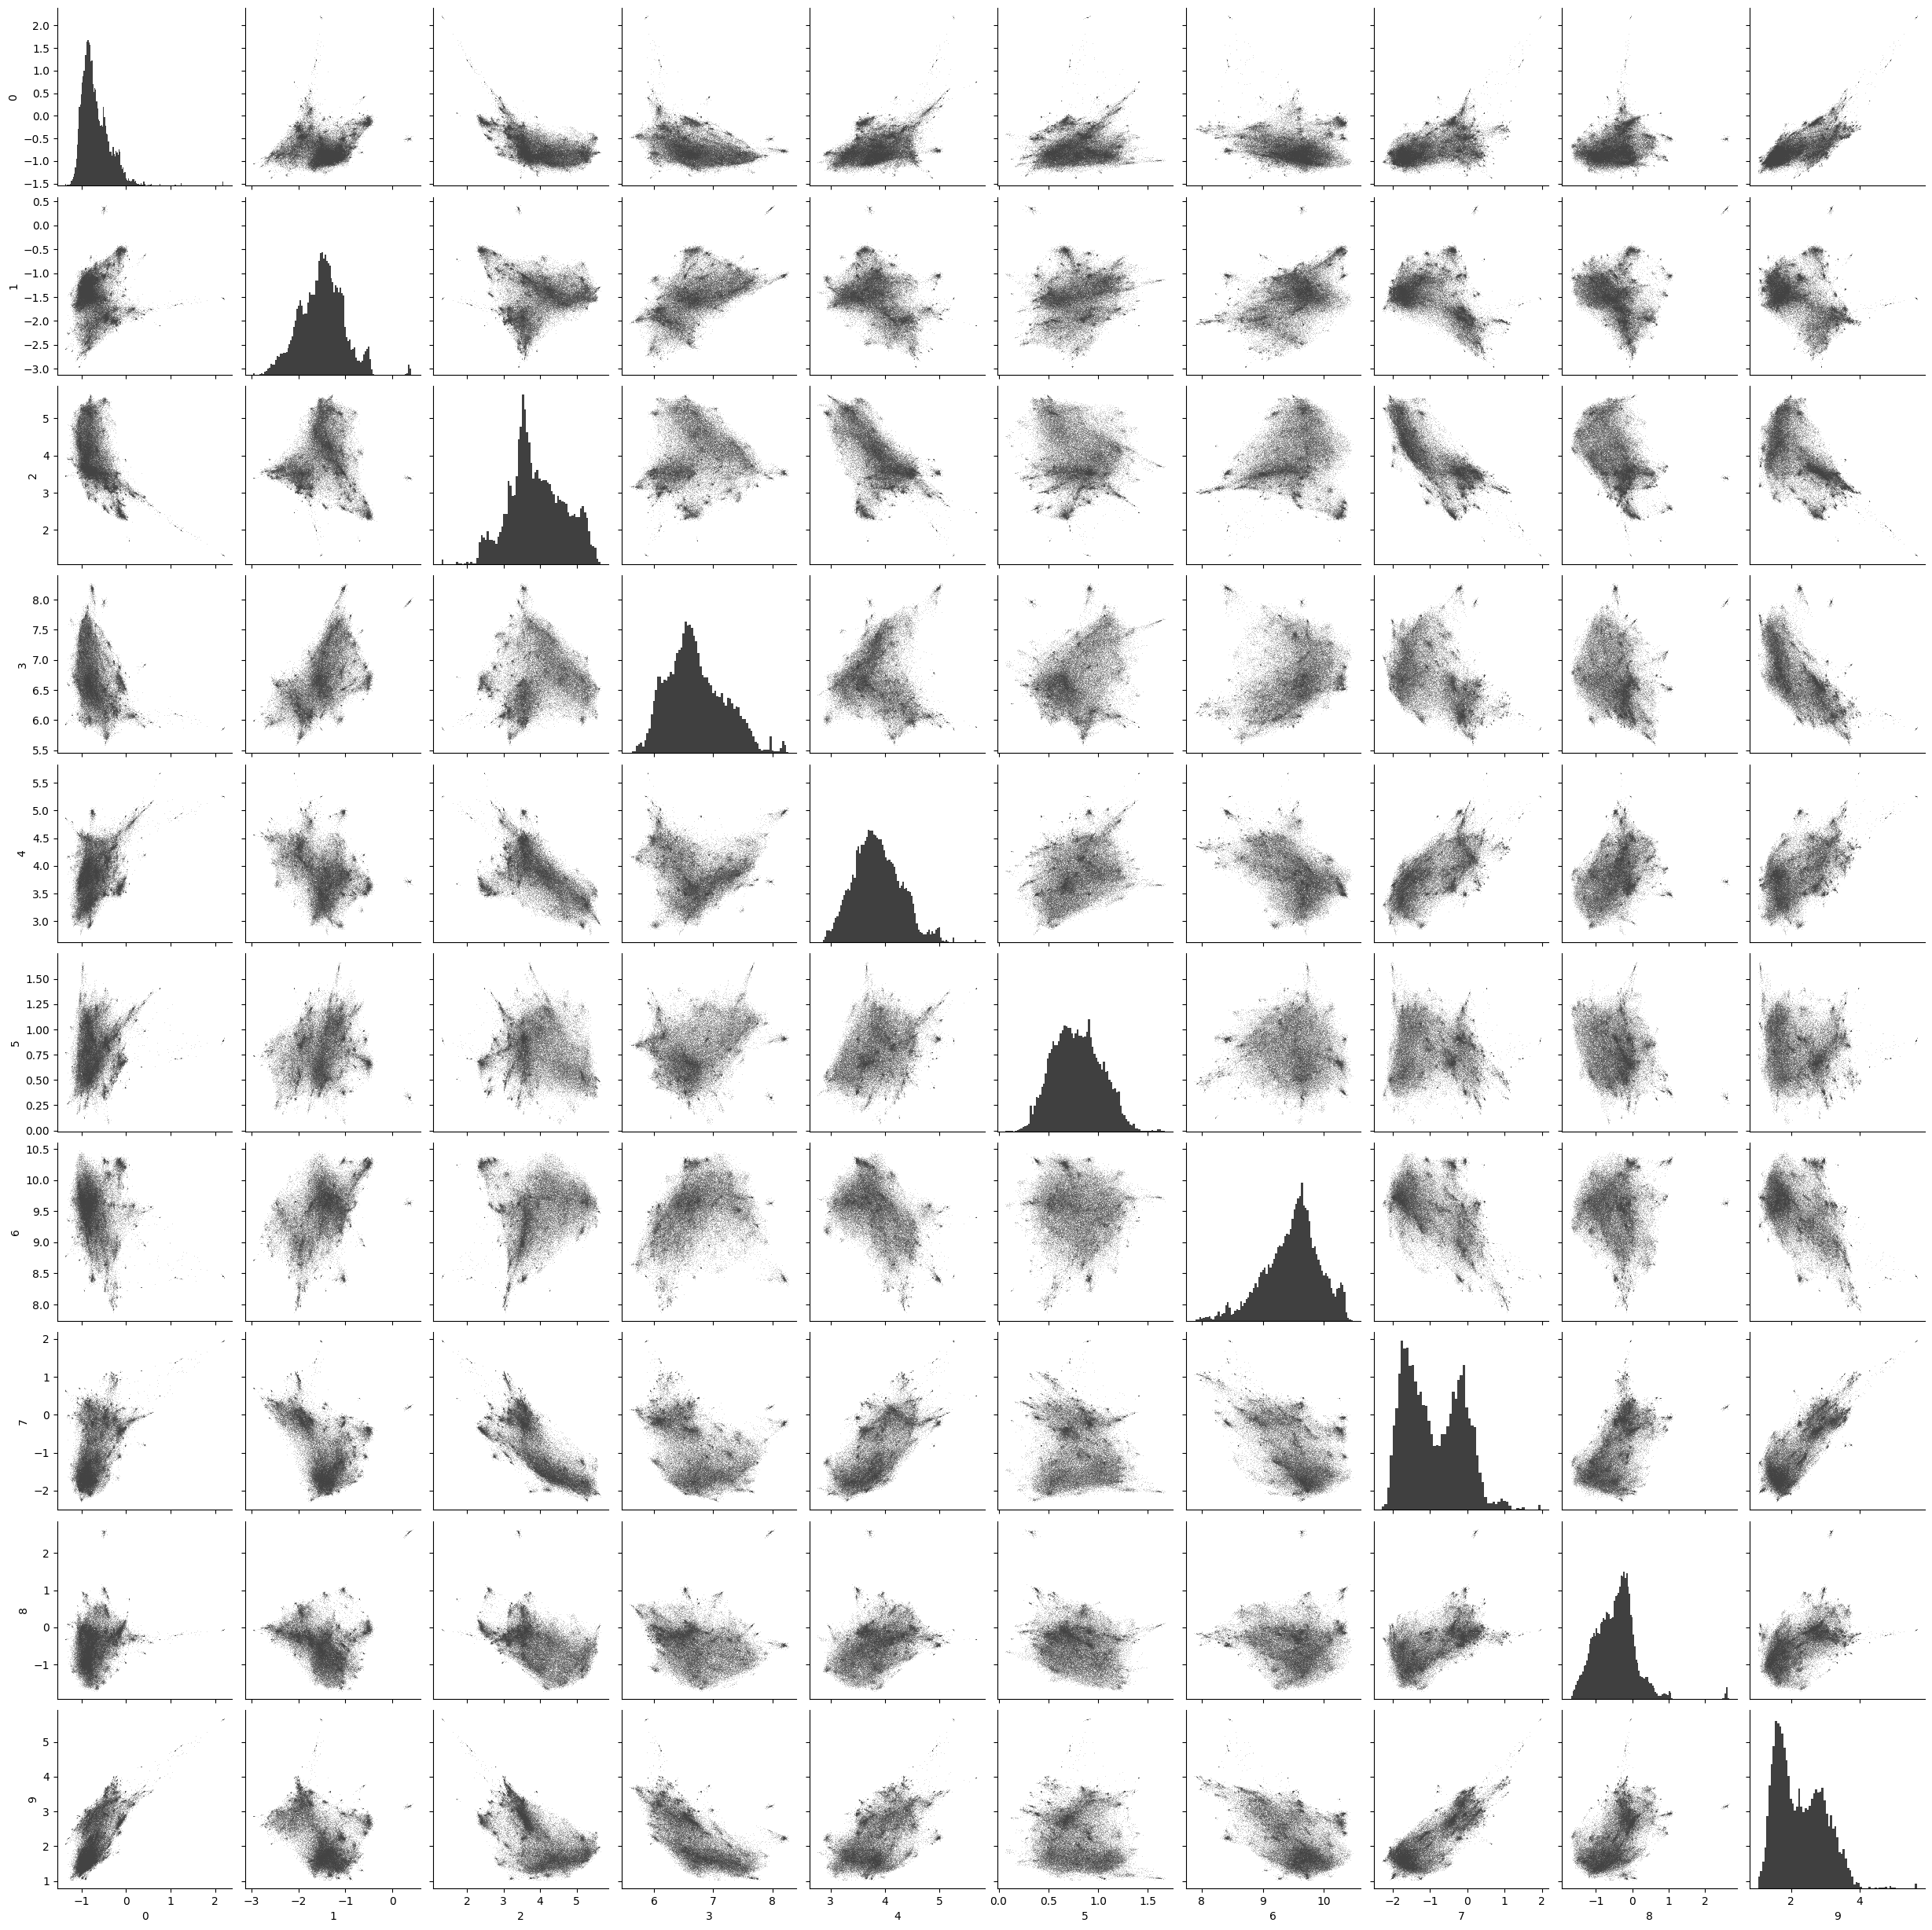

In [167]:
sns.pairplot(data = pd.DataFrame(proj), plot_kws = {'s':.1, 'c':'k'}, diag_kws = {'lw':0, 'color':'k'});

In [16]:
kmeans = KMeans(n_clusters = 5, n_init = 'auto')
kmeans.fit(emb.embeddings.values[:100])
kmeans.labels_

array([4, 4, 4, 1, 3, 4, 4, 4, 2, 4, 4, 4, 4, 3, 4, 4, 1, 2, 2, 4, 2, 4,
       4, 1, 4, 0, 3, 4, 3, 3, 2, 4, 4, 4, 3, 3, 4, 3, 4, 0, 2, 2, 2, 4,
       4, 4, 1, 2, 2, 2, 1, 2, 4, 0, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 1, 4, 1, 2, 0, 4, 4, 4, 4, 4, 0, 2, 3, 4, 1, 0, 3, 4, 2, 4, 1,
       1, 4, 4, 4, 4, 2, 3, 2, 4, 4, 2, 1], dtype=int32)

## 4. The model

Find a way to use the HDBSCAN clustering of UMAP embeddings in a full Bayesian model while incorporating effects like:
* The autocorrelation of topics (i.e., clustering in time)
* Additional topic dynamics (e.g., topic A likely to transition to topic B)
* Latent behavioral variables, also correlated in time
    * Sentiment
    * Tweeting speed vs topic "volatility"
    * Time-dependent smoothness variables
    * Obsessiveness/stickiness

Separating out these latent variables from topic should help achieve more robust discovery of topic boundaries since we can add priors on their temporal structure.

In [ ]:
# KNN on full embeddings
# cosine similarity vs distance

In [ ]:
# https://github.com/openai/openai-cookbook/blob/main/examples/Clustering.ipynb
# https://github.com/openai/openai-cookbook/blob/main/examples/Clustering_for_transaction_classification.ipynb
# https://gregorygundersen.com/blog/2020/07/14/pca-to-gplvm/
# https://arxiv.org/pdf/1810.06983.pdf
# https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html
# https://hdbscan.readthedocs.io/en/latest/soft_clustering.html
# https://umap-learn.readthedocs.io/en/latest/clustering.html